In [1]:
import numpy as np
import matplotlib.pyplot as plt
from gwsnr import GWSNR

In [ ]:
snr = GWSNR(create_new_interpolator=False, ifos=['L1'], npool=8)


Initializing GWSNR class...

Interpolator will be generated for L1 detector at ./interpolator_pickle/L1/partialSNR_dict_0.pickle
Please be patient while the interpolator is generated
Generating interpolator for ['L1'] detectors


interpolation for each mass_ratios: 100%|███████████████████████████| 50/50 [00:26<00:00,  1.92it/s]


Chosen GWSNR initialization parameters:

npool:  8
snr type:  interpolation
waveform approximant:  IMRPhenomD
sampling frequency:  2048.0
minimum frequency (fmin):  20.0
mtot=mass1+mass2
min(mtot):  2.0
max(mtot) (with the given fmin=20.0): 184.98599853446768
detectors:  ['L1']
psds:  [PowerSpectralDensity(psd_file='None', asd_file='/Users/phurailatpamhemantakumar/anaconda3/envs/ler/lib/python3.10/site-packages/bilby/gw/detector/noise_curves/aLIGO_O4_high_asd.txt')]
min(ratio):  0.1
max(ratio):  1.0
mtot resolution:  500
ratio resolution:  50
interpolator directory:  ./interpolator_pickle


In [3]:
partialsacaled = np.array(snr.snr_partialsacaled_list)
partialsacaled.shape

(1, 50, 4, 499)

In [4]:
from gwsnr import (
    antenna_response, save_pickle
)
from tqdm import tqdm

In [68]:
size1 = 20
size2 = 100

mtot_min = snr.mtot_min
detectors = snr.detector_list.copy()
detector_tensor = snr.detector_tensor_list.copy()
num_det = np.arange(len(detectors), dtype=int)
mtot_table = np.sort(
            mtot_min + snr.mtot_max - np.geomspace(mtot_min, snr.mtot_max, size2)
        )

ratio_table = np.geomspace(snr.ratio_min, snr.ratio_max, size1)

mass_1 = np.zeros((size1, size2))
mass_2 = np.zeros((size1, size2))
ratio = np.zeros((size1, size2))

for i, q in enumerate(ratio_table):
    for j, mtot in enumerate(mtot_table):
            mass_1[i, j] = mtot / (1 + q)
            mass_2[i, j] = mass_1[i, j] * q
            ratio[i, j] = q
mass_1 = np.array(mass_1)
mass_2 = np.array(mass_2)
ratio = np.array(ratio)

In [70]:
#np.sum(np.reshape(ratio.flatten(), (50,500)) != ratio)

In [71]:
print(f"Generating interpolator for {detectors} detectors")

if mtot_min < 1.0:
    raise ValueError("Error: mass too low")

# this geocent_time is only to get partialScaledSNR
geocent_time_ = 1246527224.169434  # random time from O3
theta_jn_, ra_, dec_, psi_, phase_ = np.zeros(5)
luminosity_distance_ = 100.0

# calling bilby_snr
optimal_snr_unscaled_ref = snr.compute_bilby_snr(
    mass_1=mass_1.flatten(),
    mass_2=mass_2.flatten(),
    luminosity_distance=luminosity_distance_,
    theta_jn=theta_jn_,
    psi=psi_,
    phase=phase_,
    geocent_time=geocent_time_,
    ra=ra_,
    dec=dec_,
)

Generating interpolator for ['L1'] detectors


100%|█████████████████████████████████████████████████████████| 1996/1996 [00:00<00:00, 2075.72it/s]


In [72]:
# Vectorized computation for effective luminosity distance
Fp = np.array(
    [
        antenna_response(ra_, dec_, geocent_time_, psi_, tensor, "plus")
        for tensor in detector_tensor
    ]
)
Fc = np.array(
    [
        antenna_response(ra_, dec_, geocent_time_, psi_, tensor, "cross")
        for tensor in detector_tensor
    ]
)
dl_eff = luminosity_distance_ / np.sqrt(
    Fp**2 * ((1 + np.cos(theta_jn_) ** 2) / 2) ** 2
    + Fc**2 * np.cos(theta_jn_) ** 2
)

# for partialscaledSNR
Mchirp = ((mass_1.flatten() * mass_2.flatten()) ** (3 / 5)) / ((mass_1.flatten() + mass_2.flatten()) ** (1 / 5))
Mchirp_scaled = Mchirp ** (5.0 / 6.0)
# filling in interpolation table for different detectors
snr_partial_buffer = []
for j in num_det:
    snr_partial_buffer.append(
            (dl_eff[j] / Mchirp_scaled) * optimal_snr_unscaled_ref[detectors[j]],
    )
snr_partial_ref = np.reshape(np.array(snr_partial_buffer)[0], 
                             (size1, size2))
# save array
np.save('snr_partial_2D.npy', snr_partial_ref)

In [73]:
snr_partial_ref.shape

(20, 100)

In [17]:
(snr_partial_ref.flatten()*(Mchirp_scaled/dl_eff[0]))

array([ 11.64713066,  18.94706344,  25.35638626, ...,
       668.29963554, 668.34369177, 669.07503709])

In [18]:
optimal_snr_unscaled_ref['L1']

array([ 11.64713066,  18.94706344,  25.35638626, ...,
       668.29963554, 668.34369177, 669.07503709])

In [25]:
# snr.multiprocessing_verbose = False
# mtot_min = snr.mtot_min
# detectors = snr.detector_list.copy()
# detector_tensor = snr.detector_tensor_list.copy()
# num_det = np.arange(len(detectors), dtype=int)
# mtot_table = snr.mtot_arr
# print(f"Generating interpolator for {detectors} detectors")

# if mtot_min < 1.0:
#     raise ValueError("Error: mass too low")

# # geocent_time cannot be array here
# # this geocent_time is only to get partialScaledSNR
# geocent_time_ = 1246527224.169434  # random time from O3
# theta_jn_, ra_, dec_, psi_, phase_ = np.zeros(5)
# luminosity_distance_ = 100.0

# # Vectorized computation for effective luminosity distance
# Fp = np.array(
#     [
#         antenna_response(ra_, dec_, geocent_time_, psi_, tensor, "plus")
#         for tensor in detector_tensor
#     ]
# )
# Fc = np.array(
#     [
#         antenna_response(ra_, dec_, geocent_time_, psi_, tensor, "cross")
#         for tensor in detector_tensor
#     ]
# )
# dl_eff = luminosity_distance_ / np.sqrt(
#     Fp**2 * ((1 + np.cos(theta_jn_) ** 2) / 2) ** 2
#     + Fc**2 * np.cos(theta_jn_) ** 2
# )

# ratio = snr.ratio_arr.copy()
# snr_partial_ = []
# # interpolation along mtot for each mass_ratio
# for q in tqdm(
#     ratio,
#     desc="interpolation for each mass_ratios",
#     total=len(ratio),
#     ncols=100,
# ):
#     mass_1_ = mtot_table / (1 + q)
#     mass_2_ = mass_1_ * q
#     # calling bilby_snr
#     optimal_snr_unscaled = snr.compute_bilby_snr(
#         mass_1=mass_1_,
#         mass_2=mass_2_,
#         luminosity_distance=luminosity_distance_,
#         theta_jn=theta_jn_,
#         psi=psi_,
#         phase=phase_,
#         geocent_time=geocent_time_,
#         ra=ra_,
#         dec=dec_,
#     )
#     # for partialscaledSNR
#     Mchirp = ((mass_1_ * mass_2_) ** (3 / 5)) / ((mtot_table) ** (1 / 5))
#     a2 = Mchirp ** (5.0 / 6.0)
#     # filling in interpolation table for different detectors
#     snr_partial_buffer = []
#     for j in num_det:
#         snr_partial_buffer.append((dl_eff[j] / a2) * optimal_snr_unscaled[detectors[j]])
#     snr_partial_.append(np.array(snr_partial_buffer))
# snr_partial_ = np.array(snr_partial_)
# snr.multiprocessing_verbose = True

In [26]:
# snr_partial_ref, snr_partial_[:,0,:]

In [74]:
size = 4
# q = np.random.uniform(snr.ratio_min, snr.ratio_max, size=size)
# mtot = np.random.uniform(snr.mtot_min, snr.mtot_max, size=size)
# mass_1_ = mtot / (1 + q)
# mass_2_ = mass_1_ * q
# a_1_ = np.random.uniform(-a_max, a_max, size=size)
# a_2_ = np.random.uniform(-a_max, a_max, size=size)
mass_1_ = 30.* np.ones(size)
mass_2_ = 25.* np.ones(size)


# geocent_time cannot be array here
# this geocent_time is only to get partialScaledSNR
geocent_time_ = 1246527224.169434  # random time from O3
theta_jn_, ra_, dec_, psi_, phase_ = np.zeros(5)
luminosity_distance_ = 500.0

# Vectorized computation for effective luminosity distance
Fp = np.array(
    [
        antenna_response(ra_, dec_, geocent_time_, psi_, tensor, "plus")
        for tensor in detector_tensor
    ]
)
Fc = np.array(
    [
        antenna_response(ra_, dec_, geocent_time_, psi_, tensor, "cross")
        for tensor in detector_tensor
    ]
)
dl_eff = luminosity_distance_ / np.sqrt(
    Fp**2 * ((1 + np.cos(theta_jn_) ** 2) / 2) ** 2
    + Fc**2 * np.cos(theta_jn_) ** 2
)

ratio = snr.ratio_arr.copy()
# interpolation along mtot for each mass_ratio

# calling bilby_snr
optimal_snr_unscaled = snr.compute_bilby_snr(
    mass_1=mass_1_,
    mass_2=mass_2_,
    luminosity_distance=luminosity_distance_,
    theta_jn=theta_jn_,
    psi=psi_,
    phase=phase_,
    geocent_time=geocent_time_,
    ra=ra_,
    dec=dec_,
)
# for partialscaledSNR
Mchirp = ((mass_1_ * mass_2_) ** (3 / 5)) / ((mass_1_ + mass_2_) ** (1 / 5))
Mchirp_scaled = Mchirp ** (5.0 / 6.0)
# filling in interpolation table for different detectors
snr_partial_buffer = []
for j in num_det:
    snr_partial_buffer.append(
            (dl_eff[j] / Mchirp_scaled) * optimal_snr_unscaled[detectors[j]],
    )

snr_partial_true = np.array(snr_partial_buffer)

100%|█████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 13.94it/s]


In [75]:
snr_partial_true[0]

array([2396.92829161, 2396.92829161, 2396.92829161,
       2396.92829161])

In [38]:
import numpy as np

def catmull_rom_spline(p, t):
    """1D Catmull-Rom interpolation with 4 points p, at relative position t in [0,1]."""
    M = 0.5 * np.array([
        [0,  2,  0,  0],
        [-1, 0,  1,  0],
        [2, -5,  4, -1],
        [-1, 3, -3,  1]
    ])
    T = np.array([1, t, t**2, t**3])
    return T @ M @ p

def find_index_1d(x_array, x_new):
    """Find index i so that x_array[i] <= x_new <= x_array[i+1], with clamping (array must be len >= 4)."""
    N = len(x_array)
    if x_new <= x_array[1]:
        return 1
    elif x_new >= x_array[N - 2]:
        return N - 3
    else:
        i = np.searchsorted(x_array, x_new) - 1
        return max(1, min(i, N - 3))

def catmull_rom_2d_interp(q_array, mtot_array, snr_array, q_new, mtot_new):
    """Perform 2D Catmull-Rom spline interpolation for snr_array[q, mtot] at (q_new, mtot_new)."""
    q_idx = find_index_1d(q_array, q_new)
    m_idx = find_index_1d(mtot_array, mtot_new)

    # Extract 4 points in each direction (assumes arrays are sorted and len >= 4)
    qs = q_array[q_idx - 1 : q_idx + 3]
    ms = mtot_array[m_idx - 1 : m_idx + 3]
    F = snr_array[q_idx - 1 : q_idx + 3, m_idx - 1 : m_idx + 3]  # shape (4,4)

    # Compute normalized local coordinates
    tq = (q_new - qs[1]) / (qs[2] - qs[1])
    tm = (mtot_new - ms[1]) / (ms[2] - ms[1])
    tq = np.clip(tq, 0, 1)
    tm = np.clip(tm, 0, 1)

    # Interpolate: first along mtot for each q-row, then along q
    temp = np.array([catmull_rom_spline(F[i, :], tm) for i in range(4)])
    snr_new = catmull_rom_spline(temp, tq)
    return snr_new

In [77]:
ratio_table.shape, mtot_table.shape, snr_partial_ref.shape

((20,), (100,), (20, 100))

In [78]:
i = 3
q_new = mass_2_[i] / mass_1_[i] # 25/30 # 
mtot_new = mass_1_[i] + mass_2_[i] #30 + 25 # ,
catmull_rom_2d_interp(
    ratio_table, mtot_table, snr_partial_ref,
    q_new= q_new,
    mtot_new= mtot_new,
)#* Mchirp_scaled[i]/dl_eff[0]    # scale by effective distance and chirp mass

2396.8467281083076

In [67]:
snr_partial_true[0][i]#* Mchirp_scaled[i]/dl_eff[0]

2396.928291607153

In [51]:
mass_1_,mass_2_

(array([ 12.40074326,  77.81942944,  12.74809701, 101.90713374]),
 array([12.25497886, 50.48750378, 11.69053176, 75.46294798]))

In [56]:
def cubic_spline_4pts(x, y, i):

    A = np.zeros((12, 12))
    b = np.zeros(12)

    # Cubic polynomial: a*x^3 + b*x^2 + c*x + d

    # Function values at endpoints
    A[0, 0:4] = [x[0]**3, x[0]**2, x[0], 1]
    A[1, 0:4] = [x[1]**3, x[1]**2, x[1], 1]
    A[2, 4:8] = [x[1]**3, x[1]**2, x[1], 1]
    A[3, 4:8] = [x[2]**3, x[2]**2, x[2], 1]
    A[4, 8:12] = [x[2]**3, x[2]**2, x[2], 1]
    A[5, 8:12] = [x[3]**3, x[3]**2, x[3], 1]

    b[0:6] = [y[0], y[1], y[1], y[2], y[2], y[3]]

    # First derivative continuity at x2 and x3
    A[6, 0:4] = [3*x[1]**2, 2*x[1], 1, 0]
    A[6, 4:8] = [-3*x[1]**2, -2*x[1], -1, 0]

    A[7, 4:8] = [3*x[2]**2, 2*x[2], 1, 0]
    A[7, 8:12] = [-3*x[2]**2, -2*x[2], -1, 0]

    # Second derivative continuity at x2 and x3
    A[8, 0:4] = [6*x[1], 2, 0, 0]
    A[8, 4:8] = [-6*x[1], -2, 0, 0]

    A[9, 4:8] = [6*x[2], 2, 0, 0]
    A[9, 8:12] = [-6*x[2], -2, 0, 0]

    # Natural spline boundary conditions (second derivative zero at endpoints)
    A[10, 0:4] = [6*x[0], 2, 0, 0]
    A[11, 8:12] = [6*x[3], 2, 0, 0]

    # Solve linear system
    coeffs = np.linalg.solve(A, b)

    # Return each interval's coefficients [a_i, b_i, c_i, d_i]
    return coeffs[i*4:(i+1)*4]

def find_index_1d(x_array, x_new):
    """Find index i such that x_array[i] <= x_new <= x_array[i+1], with clamping."""
    N = len(x_array)
    if x_new <= x_array[1]:
        return 1, 0
    elif x_new >= x_array[N - 2]:
        return N - 3, 1
    else:
        i = np.searchsorted(x_array, x_new) - 1
        return max(1, min(i, N - 3)), 2
    
def cubic_function_4pts(x, coeffs):
    """
    Evaluate cubic polynomial defined by 4 points at x.
    coeffs should be of the form [a, b, c, d] for the polynomial a*x^3 + b*x^2 + c*x + d
    """
    return coeffs[0] * x**3 + coeffs[1] * x**2 + coeffs[2] * x + coeffs[3]

q_array=snr.ratio_arr
mtot_array=snr.mtot_arr
snr_array=snr_partial_ref
q_new=mass_2_[i] / mass_1_[i]
mtot_new= mass_1_[i] + mass_2_[i]
"""Perform 2D Catmull-Rom interpolation."""
q_idx, int_q = find_index_1d(q_array, q_new)
m_idx, int_m = find_index_1d(mtot_array, mtot_new)

# Select 4x4 grid around (q_new, mtot_new)
qs = q_array[q_idx - 1: q_idx + 3]
ms = mtot_array[m_idx - 1: m_idx + 3]
F = snr_array[q_idx - 1: q_idx + 3, m_idx - 1: m_idx + 3]  # shape (4,4)

# Interpolate along mtot for each q-row
temp = np.zeros(4)
for i in range(4):
    coeff_ = cubic_spline_4pts(ms, F[i, :], int_m)
    temp[i] = cubic_function_4pts(mtot_new, coeff_)

# Interpolate final value along q
coeff = cubic_spline_4pts(qs, temp, int_q)
snr_new = cubic_function_4pts(q_new, coeff)

In [58]:
snr_new* Mchirp_scaled[i] / dl_eff[0]  # scale by effective distance and chirp mass

44.43943631991828

In [75]:
import jax.numpy as jnp
from jax import jit, vmap, lax

@jit
def catmull_rom_spline(p, t):
    M = 0.5 * jnp.array([
        [0,  2,  0,  0],
        [-1, 0,  1,  0],
        [2, -5,  4, -1],
        [-1, 3, -3,  1]
    ])
    T = jnp.array([1.0, t, t**2, t**3])
    return T @ M @ p

@jit
def find_index_1d(x_array, x_new):
    N = x_array.shape[0]
    i = jnp.sum(x_array <= x_new) - 1
    return jnp.clip(i, 1, N - 3)

@jit
def catmull_rom_2d_interp_single(q_array, mtot_array, snr_array, q_new, mtot_new):
    q_idx = find_index_1d(q_array, q_new)
    m_idx = find_index_1d(mtot_array, mtot_new)

    # Dynamic slices (for 4x4 neighborhood)
    F = lax.dynamic_slice(snr_array, (q_idx - 1, m_idx - 1), (4, 4))
    qs = lax.dynamic_slice(q_array, (q_idx - 1,), (4,))
    ms = lax.dynamic_slice(mtot_array, (m_idx - 1,), (4,))

    # Relative coordinates
    tq = (q_new - qs[1]) / (qs[2] - qs[1])
    tm = (mtot_new - ms[1]) / (ms[2] - ms[1])
    tq = jnp.clip(tq, 0.0, 1.0)
    tm = jnp.clip(tm, 0.0, 1.0)

    # Interpolate along mtot (columns)
    def interp_m_row(i):
        return catmull_rom_spline(F[i, :], tm)
    
    temp = jnp.stack([interp_m_row(i) for i in range(4)])
    return catmull_rom_spline(temp, tq)

@jit
def batched_catmull_rom_2d(q_array, mtot_array, snr_array, q_new_batch, mtot_new_batch):
    # Vectorize only over q_new and mtot_new
    vmapped_interp = vmap(
        lambda q, m: catmull_rom_2d_interp_single(q_array, mtot_array, snr_array, q, m),
        in_axes=(0, 0)
    )
    return vmapped_interp(q_new_batch, mtot_new_batch)


# q_array = jnp.array(snr.ratio_arr)
# mtot_array = jnp.array(snr.mtot_arr)
# snr_array = jnp.array(snr_partial_[:,0,:])
# q_new = jnp.array(q[0])
# mtot_new = jnp.array(mtot[0])

# snr_new = catmull_rom_2d_interp(q_array, mtot_array, snr_array, q_new, mtot_new)
# print(snr_new)

In [79]:
q_array = jnp.array(snr.ratio_arr)
mtot_array = jnp.array(snr.mtot_arr)
snr_array = jnp.array(snr_partial_ref)
q_new = jnp.array(mass_2_ / mass_1_)  # Example mass ratio
mtot_new = jnp.array(mass_1_ + mass_2_)  # Example total mass

# Query batch
q_new_batch = jnp.array([0.55, 0.72, 0.90])
mtot_new_batch = jnp.array([2.1, 2.5, 2.8])

# Interpolate
snr_partial_pred1 = batched_catmull_rom_2d(q_array, mtot_array, snr_array, q_new, mtot_new)
# snr_pred1 = snr_partial_pred1*(Mchirp_scaled / dl_eff[0])

In [80]:
snr_partial_pred1

Array([2396.9106, 2396.9106, 2396.9106, 2396.9106, 2396.9106,
       2396.9106, 2396.9106, 2396.9106, 2396.9106, 2396.9106],      dtype=float32)

In [76]:
snr_partial_pred1*(a2 / dl_eff[0]), optimal_snr_unscaled['L1']

(Array([522.85443, 430.64316, 321.00262, ..., 410.02454,
        170.36212, 453.03372], dtype=float32),
 array([522.88940429, 430.64745172, 321.00320745, ...,
        410.02651661, 170.36810368, 453.06071546]))

In [45]:
%timeit snr_batch = batched_catmull_rom_2d(q_array, mtot_array, snr_array, q_new, mtot_new)

235 µs ± 1.17 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [39]:
snr_partial_new

array([[2185.73692206, 1454.52121682, 1411.14488771, ...,
        2610.41192525, 2568.81510465, 1987.39630359],
       [2185.73692206, 1454.52121682, 1411.14488771, ...,
        2610.41192525, 2568.81510465, 1987.39630359],
       [1700.6577253 , 1096.48714003, 1051.06353928, ...,
        1966.9310175 , 1928.55972619, 1506.69036275]])

In [99]:
import jax.numpy as jnp
from jax import jit, vmap, lax

@jit
def find_index_1d_jax(x_array, x_new):
    N = x_array.shape[0]
    i = jnp.sum(x_array <= x_new) - 1
    i = jnp.clip(i, 1, N - 3)
    cond_0 = x_new <= x_array[1]
    cond_1 = x_new >= x_array[N - 2]
    interval_type = jnp.where(cond_0, 0, jnp.where(cond_1, 1, 2))
    return i, interval_type

@jit
def cubic_spline_4pts_jax(x, y, i):
    def row(i, coeff_idx):
        return jnp.array([x[i]**3, x[i]**2, x[i], 1.0]) if coeff_idx == 0 else jnp.zeros(4)

    A = jnp.zeros((12, 12))
    b = jnp.zeros(12)

    def set_block(A, row_idx, col_offset, coeffs):
        return A.at[row_idx, col_offset:col_offset+4].set(jnp.array(coeffs))

    # Fill A and b (fully unrolled for JAX compatibility)
    A = set_block(A, 0, 0, [x[0]**3, x[0]**2, x[0], 1])
    A = set_block(A, 1, 0, [x[1]**3, x[1]**2, x[1], 1])
    A = set_block(A, 2, 4, [x[1]**3, x[1]**2, x[1], 1])
    A = set_block(A, 3, 4, [x[2]**3, x[2]**2, x[2], 1])
    A = set_block(A, 4, 8, [x[2]**3, x[2]**2, x[2], 1])
    A = set_block(A, 5, 8, [x[3]**3, x[3]**2, x[3], 1])

    b = b.at[0:6].set(jnp.array([y[0], y[1], y[1], y[2], y[2], y[3]]))

    A = A.at[6, 0:4].set(jnp.array([3*x[1]**2, 2*x[1], 1, 0]))
    A = A.at[6, 4:8].set(jnp.array([-3*x[1]**2, -2*x[1], -1, 0]))
    A = A.at[7, 4:8].set(jnp.array([3*x[2]**2, 2*x[2], 1, 0]))
    A = A.at[7, 8:12].set(jnp.array([-3*x[2]**2, -2*x[2], -1, 0]))

    A = A.at[8, 0:4].set(jnp.array([6*x[1], 2, 0, 0]))
    A = A.at[8, 4:8].set(jnp.array([-6*x[1], -2, 0, 0]))
    A = A.at[9, 4:8].set(jnp.array([6*x[2], 2, 0, 0]))
    A = A.at[9, 8:12].set(jnp.array([-6*x[2], -2, 0, 0]))

    A = A.at[10, 0:4].set(jnp.array([6*x[0], 2, 0, 0]))
    A = A.at[11, 8:12].set(jnp.array([6*x[3], 2, 0, 0]))

    coeffs = jnp.linalg.solve(A, b)
    return coeffs[i*4:(i+1)*4]

@jit
def cubic_function_4pts_jax(x, coeffs):
    return coeffs[0]*x**3 + coeffs[1]*x**2 + coeffs[2]*x + coeffs[3]

@jit
def spline_interp_2d_single(q_array, mtot_array, snr_array, q_new, mtot_new):
    q_idx, int_q = find_index_1d_jax(q_array, q_new)
    m_idx, int_m = find_index_1d_jax(mtot_array, mtot_new)

    F = lax.dynamic_slice(snr_array, (q_idx - 1, m_idx - 1), (4, 4))
    qs = lax.dynamic_slice(q_array, (q_idx - 1,), (4,))
    ms = lax.dynamic_slice(mtot_array, (m_idx - 1,), (4,))

    temp = jnp.zeros(4)
    for i in range(4):
        coeff_ = cubic_spline_4pts_jax(ms, F[i, :], int_m)
        temp = temp.at[i].set(cubic_function_4pts_jax(mtot_new, coeff_))

    coeff_final = cubic_spline_4pts_jax(qs, temp, int_q)
    return cubic_function_4pts_jax(q_new, coeff_final)

# Vectorized version
@jit
def batched_spline_interp(q_array, mtot_array, snr_array, q_batch, mtot_batch):
    vmapped_interp = vmap(lambda q, m: spline_interp_2d_single(q_array, mtot_array, snr_array, q, m), in_axes=(0, 0))
    return vmapped_interp(q_batch, mtot_batch)

In [100]:
q_array = jnp.array(snr.ratio_arr)
mtot_array = jnp.array(snr.mtot_arr)
snr_array = jnp.array(snr_partial_[:,0,:])
q_new = jnp.array(q)
mtot_new = jnp.array(mtot)


# Interpolate
snr_partial_pred2 = batched_catmull_rom_2d(q_array, mtot_array, snr_array, q_new, mtot_new)
snr_pred2 = snr_partial_pred1*(a2 / dl_eff[0])

In [101]:
snr_pred1``, snr_pred2

(Array([522.85443, 430.64316, 321.00262, ..., 410.02454,
        170.36212, 453.03372], dtype=float32),
 Array([522.85443, 430.64316, 321.00262, ..., 410.02454,
        170.36212, 453.03372], dtype=float32))

In [105]:
geocent_time_ = 1246527224.169434  # random time from O3
theta_jn_, ra_, dec_, psi_, phase_ = np.zeros(5)
luminosity_distance_ = 100.0
snr_pred3 = snr.snr(mass_1=mass_1_,
        mass_2=mass_2_,
        luminosity_distance=luminosity_distance_,
        theta_jn=theta_jn_,
        psi=psi_,
        phase=phase_,
        geocent_time=geocent_time_,
        ra=ra_,
        dec=dec_,
    )['L1']

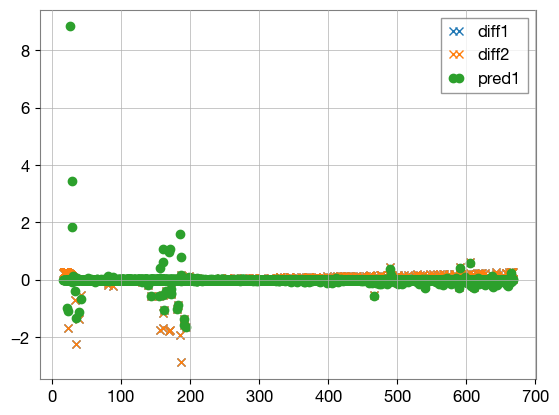

In [108]:
import matplotlib.pyplot as plt
snr_true = optimal_snr_unscaled['L1']
idx = snr_true> 0
plt.plot(snr_true[idx],snr_true[idx]-snr_pred1[idx], label='diff1', marker='x', linestyle='None', color='C0')
plt.plot(snr_true[idx],snr_true[idx]-snr_pred2[idx], label='diff2', marker='x', linestyle='None', color='C1')
plt.plot(snr_true[idx], snr_true[idx]-snr_pred3[idx], label='pred1', marker='o', linestyle='None', color='C2')
plt.legend()
plt.show()

In [44]:
idx_no = abs(snr_true[idx]-snr_batch[idx])>1
snr_true[idx][idx_no], snr_batch[idx][idx_no]

(array([1609.0088373 , 1130.62721984, 2830.24120997,
        2834.30848108, 2816.66420316, 2837.9980039 ,
        2808.26012532, 2838.7975963 , 2834.87381701,
        2831.80851502, 2810.54504652, 1536.15323049,
        2826.0876688 , 1710.51857877, 1145.07116205,
        2830.7712454 , 2787.98064342, 1270.49799518,
        1190.39652363, 2794.13600757, 2824.71821444,
        1317.34811655, 1163.3988352 ]),
 Array([1614.9395, 1132.0879, 2788.6804, 2803.6162, 2796.3408,
        2805.8687, 2806.6282, 2799.209 , 2796.3445, 2806.5635,
        2805.4143, 1550.6266, 2803.1323, 1713.3921, 1162.6875,
        2806.6282, 2928.6113, 1285.6229, 1193.2913, 2783.1853,
        2803.2961, 1323.7009, 1174.3912], dtype=float32))